<a href="https://colab.research.google.com/github/phmorris610/BaseballAnalytics/blob/main/Batting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Advanced Baseball Statistics (Batting)

In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()
bat = pd.read_csv('Batting.csv')

Saving Batting.csv to Batting.csv


In [ ]:
bat.shape

(96600, 24)

In [ ]:
bat.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'G_batting', 'AB',
       'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP',
       'SH', 'SF', 'GIDP', 'G_old'],
      dtype='object')

First we are going to drop some unneeded columns right of the bat (pun)

In [3]:
bat.drop('G_old', axis=1, inplace=True)
bat.drop('stint', axis=1, inplace=True)
bat.drop('lgID', axis=1, inplace=True)
bat.drop('teamID', axis=1, inplace=True)

In [ ]:
yrs = bat['yearID']
yrs.sort_values(ascending=False)

52364    2012
55514    2012
92423    2012
21035    2012
28652    2012
         ... 
6363     1871
91332    1871
94955    1871
5281     1871
52723    1871
Name: yearID, Length: 96600, dtype: int64

We can see that these data span from 1871 to 2012. What I would like to do is use 2000-2010 as a training set and 2011 as a testing set (2012 has too many nul values), also we will not be considering batters with less than 90 games.

In [4]:
bat = bat[bat['G_batting'] >= 90]
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
bat = bat[bat['yearID'].isin(years)]

Now we will add some extra statistics, nothing crazy mainly OPS which is a measure of power hitting.

In [5]:
bat['Ave'] = bat['H'] / bat['AB']  # Add some columns, Batting Average, and On Base Plus Slugging, (other follow)
bat['OBP'] = (bat['H'] + bat['BB'] + bat['HBP']) / (bat['AB'] + bat['BB'] + bat['SF'] + bat['HBP'])
bat['1B'] = bat['H'] - (bat['2B'] + bat['3B'] + bat['HR'])
bat['TB'] = bat['1B'] + 2 * bat['2B'] + 3 * bat['3B'] + 4 * bat['HR']
bat['SLG'] = bat['TB'] / bat['AB']
bat['OPS'] = bat['OBP'] / bat['SLG']

A batting average above 200 is considered respectable, but over 300 is considered elite, what I would like to 
is pick the player attributes that contribute to not only a high average but also a high OPS which is a measure of
power, therefore I will code ave over 300 and ops over 800 a success and else a failure

Now we will create response variables.

In [6]:
batAve = bat.copy()
batOPS = bat.copy()
batAve['response'] = np.where((batAve['Ave'] > .300), 1, 0)
batOPS['response'] = np.where((batOPS['OPS'] > .800), 1, 0)

Now we are left with only playerID and yearID as the categorical variables, but we are just defining
what goes into a high batting average or ops, so we can now drop yearID and playerID

In [7]:
batForNames = bat.copy()  # for later reference
# bat.drop('playerID', axis=1, inplace=True)

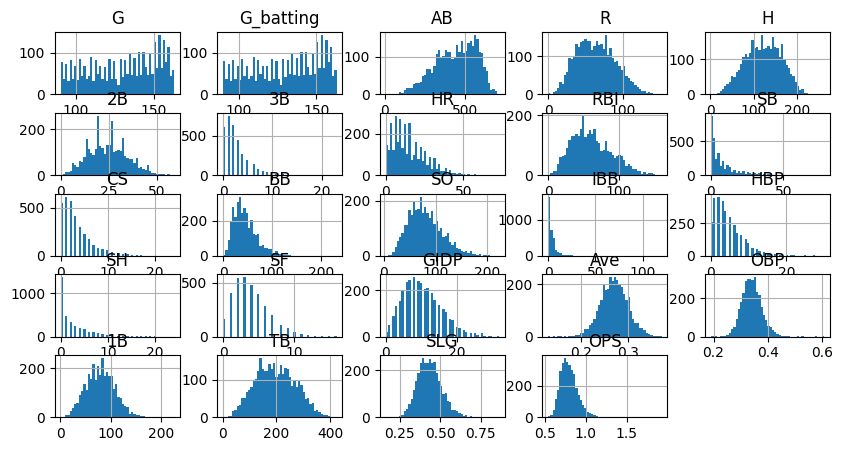

In [ ]:
Feat = ['G', 'G_batting', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
       'Ave', 'OBP', '1B', 'TB', 'SLG', 'OPS']
bat[Feat].hist(bins=50, figsize=(10, 5))
plt.show()

The distributions are what you would expect, some skewnes but nothing that would not expect to see.

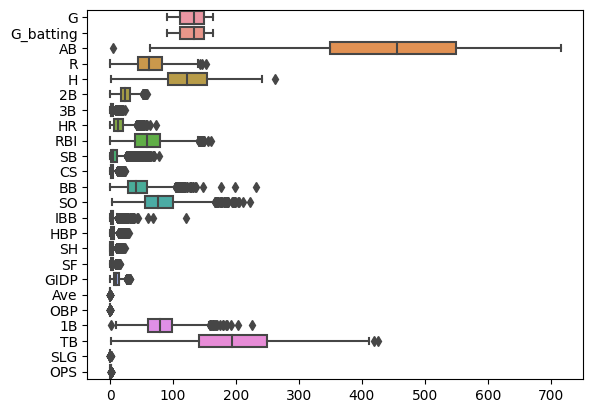

In [ ]:
Feat = ['G', 'G_batting', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
       'Ave', 'OBP', '1B', 'TB', 'SLG', 'OPS']
sns.boxplot(bat[Feat], orient='h')
plt.show()

We can see Stolen Bases and Walks have some outliers, as an aside to the main goal of this project I would like to identify some of those outliers to target some One Base Percentage a or Stolen Base potential

Now I will set up the data for Feature Correlation.

In [8]:
FeatAve = ['G', 'G_batting', 'AB', 'R', 'H', '2B', '3B', 'SB', 'CS', 'HR',
        'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'OBP', '1B', 'TB']
batXtrAve = batAve[FeatAve]
FeatOPS = ['G', 'G_batting', 'AB', 'R', 'H', '2B', '3B', 'SB', 'CS', 'HR',
        'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'Ave', 'OBP', '1B', 'TB']
batXtrOPS = batOPS[FeatOPS]
y1 = batAve['response']
y2 = batOPS['response']

Scale the data (we will need this later)

In [ ]:
scaler = Scaler()
scaler.fit(batXtrAve)
X1 = scaler.transform(batXtrAve)
scaler.fit(batXtrOPS)
X2 = scaler.transform(batXtrOPS)

In [ ]:
def extraTree(x, y, n):
    model = ExtraTreesClassifier()
    model.fit(x, y)
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    feat_importances.nlargest(n).plot(kind='barh')
    plt.show()
    feat = []
    feat.append(feat_importances.nlargest(n))
    return feat
  

Feature Correlation for Average


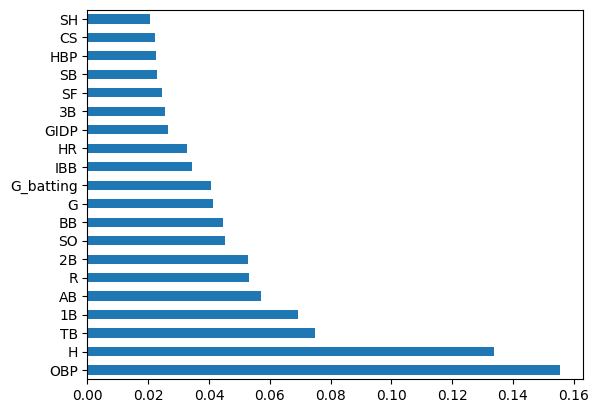

[OBP          0.155420
 H            0.133653
 TB           0.074852
 1B           0.069257
 AB           0.056955
 R            0.053226
 2B           0.052784
 SO           0.045177
 BB           0.044465
 G            0.041231
 G_batting    0.040755
 IBB          0.034392
 HR           0.032639
 GIDP         0.026655
 3B           0.025568
 SF           0.024391
 SB           0.022989
 HBP          0.022710
 CS           0.022240
 SH           0.020640
 dtype: float64]

In [ ]:
print('Feature Correlation for Average')
extraTree(batXtrAve, y1, 40)

The highest correlated features are One Base Percentage, Hits, Total Bases, Singles, and At Bats.

Feature Correlation for OPS


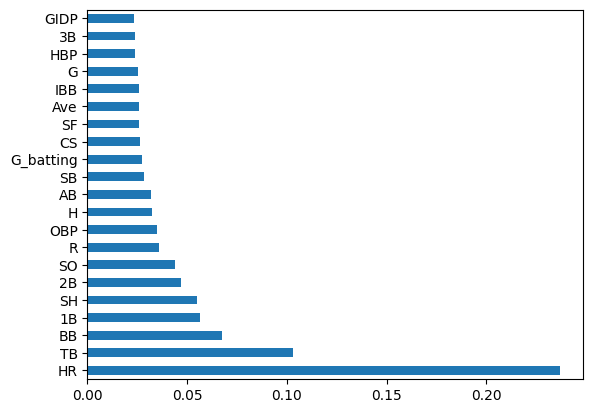

[HR           0.236843
 TB           0.103075
 BB           0.067614
 1B           0.056232
 SH           0.054747
 2B           0.046721
 SO           0.043652
 R            0.035881
 OBP          0.034662
 H            0.032564
 AB           0.031911
 SB           0.028590
 G_batting    0.027441
 CS           0.026103
 SF           0.025981
 Ave          0.025973
 IBB          0.025873
 G            0.025435
 HBP          0.023773
 3B           0.023719
 GIDP         0.023211
 dtype: float64]

In [ ]:
print('Feature Correlation for OPS')
extraTree(batXtrOPS, y2, 40)

The highest correlated features are Home Runs, Total Bases, with a cascading correlation plot from there.

Now we will split the data into training and testing, 2011 will be our testing set.

In [9]:
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
# Average
Xa_train = batAve[batAve['yearID'].isin(years)]
ya_train = Xa_train.pop('response')
Xa_test = batAve[batAve['yearID'].isin([2011])]
ya_test = Xa_test.pop('response')
# OPS
Xo_train = batOPS[batOPS['yearID'].isin(years)]
yo_train = Xo_train.pop('response')
Xo_test = batOPS[batOPS['yearID'].isin([2011])]
yo_test = Xo_test.pop('response')

In [10]:
FeatAve = ['G', 'G_batting', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
       'OBP', '1B', 'TB', 'SLG', 'OPS']
FeatOPS = ['G', 'G_batting', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
       'Ave', 'OBP', '1B', 'TB', 'SLG']
Xa_train = Xa_train[FeatAve]
Xa_test = Xa_test[FeatAve]
Xo_train = Xo_train[FeatOPS]
Xo_test = Xo_test[FeatOPS]

Now we will put these data through a k-Fold Cross validation feature selection function

LR: 0.995704 (0.003923)
KNN: 0.913103 (0.016518)
NB: 0.770718 (0.036809)
SVC: 0.915096 (0.022260)


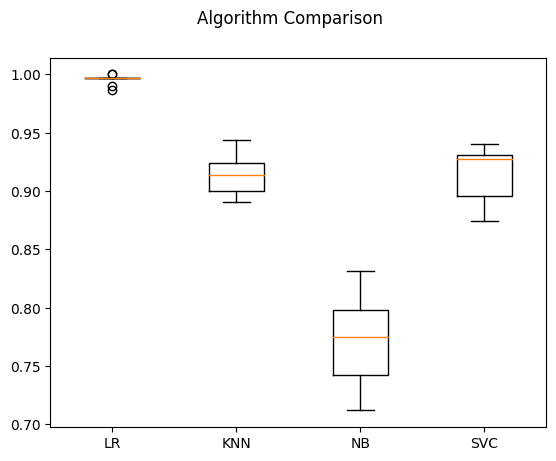

In [11]:
import warnings
warnings.filterwarnings("ignore")
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
#
seed = 8
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, random_state=None)
    cv_results = model_selection.cross_val_score(
        model, Xa_train, ya_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (
        name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

It's important to remember that our data is very imbalanced, we are attempting to identify a very small portion of the data, so a high accuracy is to be expected. Let's dig into each of these seperately.

In [16]:
model1 = svm.SVC(kernel='linear')
model1.fit(Xa_train, ya_train)
y_pred = model1.predict(Xa_test)
accuracy = accuracy_score(ya_test, y_pred)
precision = precision_score(ya_test, y_pred)
recall = recall_score(ya_test, y_pred)
print(f'Accuracy for our SVM is: {accuracy} Precision for our SVM is: {precision}')
print(f'Recall for our SVM is: {recall}')

Accuracy for our SVM is: 0.9962825278810409 Precision for our SVM is: 0.9696969696969697
Recall for our SVM is: 1.0


accuracy: 0.9962825278810409, recall: 1.0, precision: 0.9696969696969697


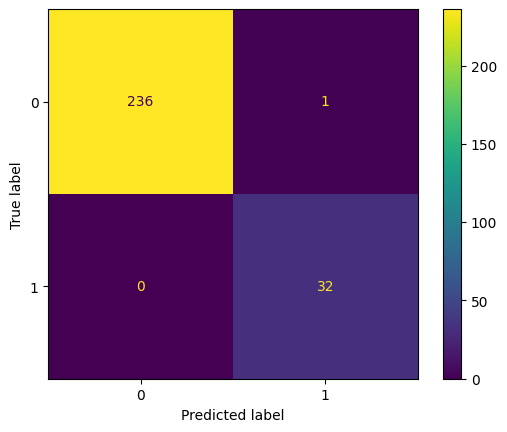

In [ ]:
cm = confusion_matrix(ya_test, y_pred)
print(f"accuracy: {accuracy}, recall: {recall}, precision: {precision}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [32]:
import warnings
warnings.filterwarnings("ignore")
lmodel = LogisticRegression()
lmodel.fit(Xa_train, ya_train)
y_pred = lmodel.predict(Xa_test)
accuracy = accuracy_score(ya_test, y_pred)
precision = precision_score(ya_test, y_pred)
recall = recall_score(ya_test, y_pred)
#f1_score = f1_score(ya_test, y_pred)
print(f'Accuracy for our LR is: {accuracy} Precision for our LR is: {precision}')
print(f'Recall for our LR is: {recall}')

Accuracy for our LR is: 1.0 Precision for our LR is: 1.0
Recall for our LR is: 1.0


accuracy: 1.0, recall: 1.0, precision: 1.0


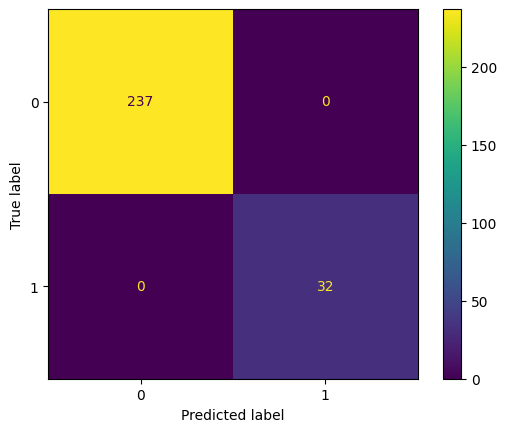

In [34]:
cm = confusion_matrix(ya_test, y_pred)
print(f"accuracy: {accuracy}, recall: {recall}, precision: {precision}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(Xa_train, ya_train)
y_pred = neighbors.predict(Xa_test)
accuracy = accuracy_score(ya_test, y_pred)
precision = precision_score(ya_test, y_pred)
recall = recall_score(ya_test, y_pred)
print(f'Accuracy for our knn is: {accuracy} Precision for our knn is: {precision}')
print(f'Recall for our knn is: {recall}')

Accuracy for our knn is: 0.9368029739776952 Precision for our knn is: 0.9411764705882353
Recall for our knn is: 0.5


accuracy: 0.9368029739776952, recall: 0.5, precision: 0.9411764705882353


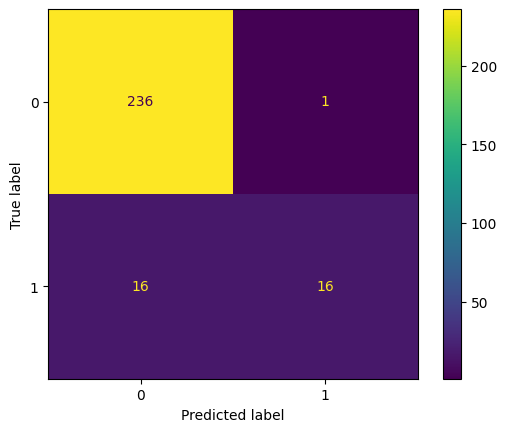

In [ ]:
cm = confusion_matrix(ya_test, y_pred)
print(f"accuracy: {accuracy}, recall: {recall}, precision: {precision}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
gnb = GaussianNB()
gnb.fit(Xa_train, ya_train)
y_pred = gnb.predict(Xa_test)
accuracy = accuracy_score(ya_test, y_pred)
precision = precision_score(ya_test, y_pred)
recall = recall_score(ya_test, y_pred)
print(f'Accuracy for our NB is: {accuracy} Precision for our NB is: {precision}')
print(f'Recall for our NB is: {recall}')

Accuracy for our NB is: 0.8513011152416357 Precision for our NB is: 0.4230769230769231
Recall for our NB is: 0.6875


accuracy: 0.8513011152416357, recall: 0.6875, precision: 0.4230769230769231


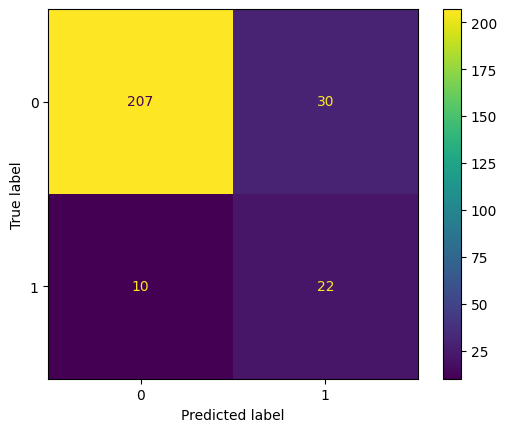

In [ ]:
cm = confusion_matrix(ya_test, y_pred)
print(f"accuracy: {accuracy}, recall: {recall}, precision: {precision}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

The Logistic Regression model seems to be perfect, this is very suspect but it can be tested. Below I will locate the ones and the predicted ones, then print out the predicted players. I can be shown that most of these have an OPS over 700.

In [36]:
modelPrediction = list(lmodel.predict(Xa_test))
moPred = []
for index, item in enumerate(modelPrediction, 0):
    if item == 1:
        moPred.append(index)
    else:
        pass

In [37]:
print(modelPrediction)
print(moPred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[12, 17, 25, 27, 36, 37, 42, 45, 66, 83, 87, 101, 126, 132, 136, 137, 150, 159, 163, 165, 167, 168, 173, 178, 180, 194, 200, 214, 242, 252, 255, 266]


In [44]:
Xa_test.iloc[101]

G            124.000000
G_batting    124.000000
AB           421.000000
R             59.000000
H            127.000000
2B            27.000000
3B             0.000000
HR            14.000000
RBI           69.000000
SB             0.000000
CS             1.000000
BB            59.000000
SO            71.000000
IBB            5.000000
HBP            3.000000
SH             0.000000
SF             8.000000
GIDP           6.000000
OBP            0.384929
1B            86.000000
TB           196.000000
SLG            0.465558
OPS            0.826811
Name: 37389, dtype: float64